### Zadanie 18 — (15p) 
Dla podzbioru zbioru `IoT-23` (zobacz np. Kaggle) zastosuj znane Ci techniki wykrywania klastrów oraz anomalii. Oczywiście przy podziale na klastry nie bierz pod uwagę etykiet. W zależności od mocy obliczeniowej, którą dysponujesz możesz analizować większy lub mniejszy podzbiór danych. Możesz również rozważyć wykorzystanie GPU lub utworzenie klastra obliczeniowego (zobacz np. tutaj).
- $a)$ Dla różnej liczby klastrów $k$ zbadaj w jakim stopniu wykryte klastry odpowiadają etykietom (np. procentowy udział etykiet w każdym klastrze). Dla różnych wartości $k$ zbadaj również ile jest anomalii i czy są one związane z jedną konkretną etykietą. W oparciu o powyższą analizę ustal sensowną wartość $k$ i porównaj ją z mocą zbioru etykiet oraz z wartością $k$ uzyskaną w oparciu o *elbow method*.
- $b)$ Porównaj wyniki klasteryzacji dla danych oryginalnych i zredukowanych przez *PCA*. Sprawdź jak na te wyniki wpływa normalizacja danych. Do oceny podziału na klastry weź pod uwagę Silhouette Score, a także miary wykorzystujące fakt, że znamy prawdziwe etykiety (np. purity).
- $c)$ Spróbuj ustalić, które cechy są kluczowe przy podziale obserwacji na klastry (np. mapa cieplna z dendrogramem dla niewielkiej reprezentatywnej próbki obserwacji, wykorzystanie *PCA* i obrazowanie danych w przestrzeni 2D z użyciem *biplot*).

In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [6]:
df = pd.read_csv('/home/dominik/Studia/Magisterka/M-2-Semestr/AAD/lab5/Iot-23/cleaned_data.csv')
df.head()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,0.003497,0,0,0.0,5.0,212.0,3.0,144.0,Benign,0,...,0,0,0,0,0,0,0,1,0,0
1,0.036724,34,311,0.0,1.0,62.0,1.0,339.0,Benign,0,...,0,0,0,0,0,0,0,1,0,0
2,384.518261,15072,0,0.0,48.0,16416.0,0.0,0.0,Benign,0,...,0,0,0,1,0,0,0,0,0,0
3,0.270332,48,48,0.0,1.0,76.0,1.0,76.0,Benign,0,...,0,0,0,0,0,0,0,1,0,0
4,0.111429,48,48,0.0,1.0,76.0,1.0,76.0,Benign,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
label_names = df['label'].unique()
print('Labels:', label_names)
print('Labels count:', len(label_names))
print(df['label'].value_counts())

Labels: ['Benign' 'PartOfAHorizontalPortScan' 'C&C' 'Attack' 'Okiru' 'DDoS'
 'FileDownload']
Labels count: 7
label
Benign                       26001
PartOfAHorizontalPortScan    12369
C&C                           5618
Attack                        3814
Okiru                          163
DDoS                            36
FileDownload                     2
Name: count, dtype: int64


In [8]:
labels = df['label']

data = df.drop(columns=['label'])

# Normalizacja danych
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled.head()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_icmp,proto_tcp,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,-0.024214,-0.008736,-0.005011,-0.026406,-0.013392,-0.014783,-0.005343,-0.005017,-0.094961,0.390519,...,-0.007906,-0.106864,-0.006455,-1.389327,-0.032931,-0.023723,-0.230463,1.924784,-0.006455,-0.010206
1,-0.024165,-0.008733,-0.004808,-0.026406,-0.013402,-0.014792,-0.007166,-0.004895,-0.094961,-2.560693,...,-0.007906,-0.106864,-0.006455,-1.389327,-0.032931,-0.023723,-0.230463,1.924784,-0.006455,-0.010206
2,0.539458,-0.007134,-0.005011,-0.026406,-0.013284,-0.013746,-0.008078,-0.005108,-0.094961,-2.560693,...,-0.007906,-0.106864,-0.006455,0.719773,-0.032931,-0.023723,-0.230463,-0.519539,-0.006455,-0.010206
3,-0.023823,-0.008731,-0.004980,-0.026406,-0.013402,-0.014791,-0.007166,-0.005060,-0.094961,-2.560693,...,-0.007906,-0.106864,-0.006455,-1.389327,-0.032931,-0.023723,-0.230463,1.924784,-0.006455,-0.010206
4,-0.024056,-0.008731,-0.004980,-0.026406,-0.013402,-0.014791,-0.007166,-0.005060,-0.094961,-2.560693,...,-0.007906,-0.106864,-0.006455,-1.389327,-0.032931,-0.023723,-0.230463,1.924784,-0.006455,-0.010206


k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10


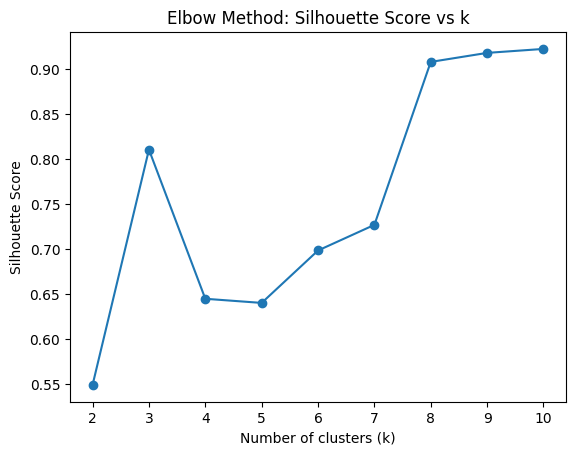

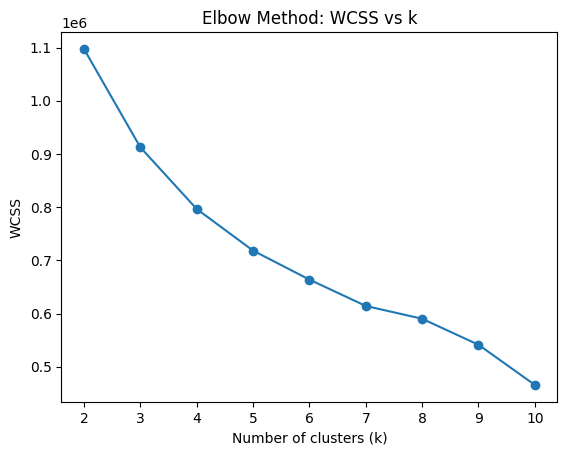

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Testowanie różnych wartości k
k_values = range(2, 11)
silhouette_scores = []
cluster_labels = {}
wcss = []

for k in k_values:
    print('k =', k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)
    silhouette = silhouette_score(data_scaled, clusters)
    
    silhouette_scores.append(silhouette)
    wcss.append(kmeans.inertia_)
    cluster_labels[k] = clusters

# Znalezienie optymalnego k metodą łokcia
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Elbow Method: Silhouette Score vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method: WCSS vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()


In [10]:
silhouette_score(data_scaled, labels)

np.float64(-0.13568578065992495)

In [11]:
# Wybieramy optymalne k (np. 4 dla przykładu)
def plot_pca_clusters(labels, clusters):
    # Procentowy udział etykiet w klastrach
    cluster_analysis = pd.DataFrame({'Cluster': clusters, 'Label': labels})
    cluster_distribution = cluster_analysis.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)
    cluster_percentages = cluster_distribution.div(cluster_distribution.sum(axis=1), axis=0) * 100

    print("Procentowy udział etykiet w klastrach:")
    print(cluster_percentages)


In [12]:
for k, clusters in cluster_labels.items():
    print('~' * 40)
    print('k =', k)
    plot_pca_clusters(labels, clusters)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
k = 2
Procentowy udział etykiet w klastrach:
Label      Attack     Benign        C&C      DDoS  FileDownload     Okiru  \
Cluster                                                                     
0        8.367338  55.146768   8.909219  0.078979      0.004388  0.357597   
1        0.000000  35.687732  64.312268  0.000000      0.000000  0.000000   

Label    PartOfAHorizontalPortScan  
Cluster                             
0                        27.135711  
1                         0.000000  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
k = 3
Procentowy udział etykiet w klastrach:
Label      Attack      Benign       C&C      DDoS  FileDownload     Okiru  \
Cluster                                                                     
0        8.017153   53.751077  11.80922  0.075673      0.004204  0.342631   
1        0.000000  100.000000   0.00000  0.000000      0.000000  0.000000   
2        0.000000  100.000000   0.00000  0.000000      0.000000

In [13]:
from sklearn.ensemble import IsolationForest

# Trening Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(data_scaled)

# Dodanie kolumny z anomaliami do DataFrame
anomalous_data = data[anomalies == -1]

print(f"Liczba wykrytych anomalii: {len(anomalous_data)}")

# Sprawdzenie związku anomalii z etykietami
anomalies_labels = labels[anomalous_data.index]
print('-' * 50)
print(anomalies_labels.value_counts())
print('-' * 50)
print(labels.value_counts())
print('-' * 50)
print((anomalies_labels.value_counts() / labels.value_counts()).sort_values(ascending=False))
print('-' * 50)



Liczba wykrytych anomalii: 2398
--------------------------------------------------
label
Benign                       1653
PartOfAHorizontalPortScan     559
C&C                           149
DDoS                           25
Attack                          9
FileDownload                    2
Okiru                           1
Name: count, dtype: int64
--------------------------------------------------
label
Benign                       26001
PartOfAHorizontalPortScan    12369
C&C                           5618
Attack                        3814
Okiru                          163
DDoS                            36
FileDownload                     2
Name: count, dtype: int64
--------------------------------------------------
label
FileDownload                 1.000000
DDoS                         0.694444
Benign                       0.063574
PartOfAHorizontalPortScan    0.045194
C&C                          0.026522
Okiru                        0.006135
Attack                       0.002

b) Porównaj wyniki klasteryzacji dla danych oryginalnych i zredukowanych przez PCA.
Sprawdź jak na te wyniki wpływa normalizacja danych. Do oceny podziału na kla-
stry weź pod uwagę Silhouette Score, a także miary wykorzystujące fakt, że znamy
prawdziwe etykiety (np. purity).

#### Dane znormalizowane

In [14]:
# Redukcja wymiarów do 2 za pomocą PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)


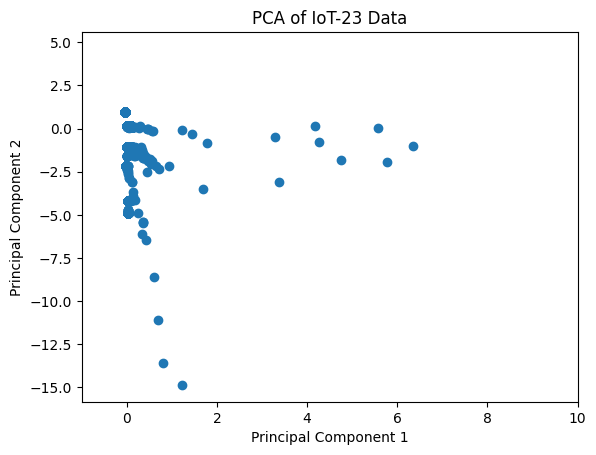

[[ 0.01157215 -1.05912622]
 [ 0.02789049 -4.18113031]
 [-0.00422516 -2.15420484]
 ...
 [-0.01235682 -2.14757892]
 [-0.01273586 -2.14727399]
 [-0.01312203 -2.14696311]]


In [15]:
# plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels.map({'Benign': 0, 'Attack': 1}), cmap='viridis', alpha=0.5)
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.xlim(-1, 10)
plt.title('PCA of IoT-23 Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.colorbar(label='Label')
plt.show()
print(data_pca)

In [16]:
silhouette_scores_pca = []
cluster_labels_pca = {}
wcss_pca = []

for k in k_values:
    print('k =', k)
    # Klasteryzacja na danych zredukowanych
    kmeans_pca = KMeans(n_clusters=5, random_state=42)
    clusters_pca = kmeans_pca.fit_predict(data_pca)
    silhouette_pca = silhouette_score(data_pca, clusters_pca)
    
    silhouette_scores_pca.append(silhouette_pca)
    wcss_pca.append(kmeans_pca.inertia_)
    cluster_labels_pca[k] = clusters_pca

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10


In [17]:
# Funkcja do obliczenia purity
def purity_score(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

purities_original = []
purities_pca = []

for k in k_values:
    # Purity dla danych oryginalnych
    purity_original = purity_score(labels, cluster_labels[k])
    purities_original.append(purity_original)
    # Purity dla danych zredukowanych przez PCA
    purity_pca = purity_score(labels, cluster_labels_pca[k])
    purities_pca.append(purity_pca)

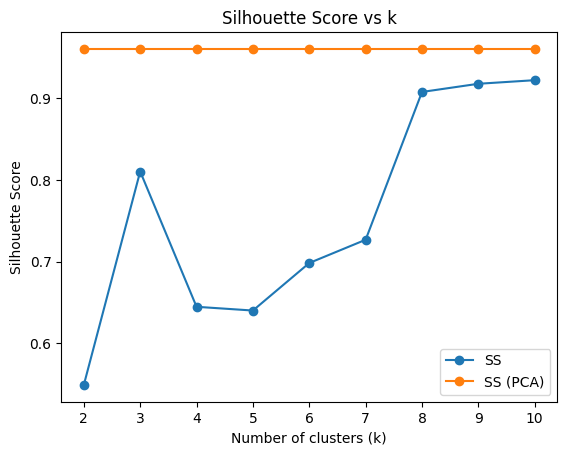

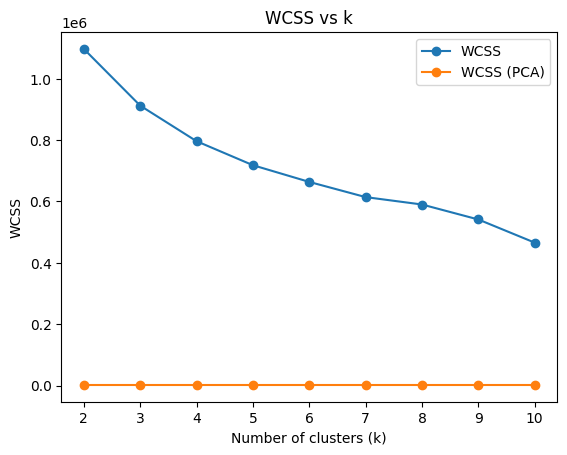

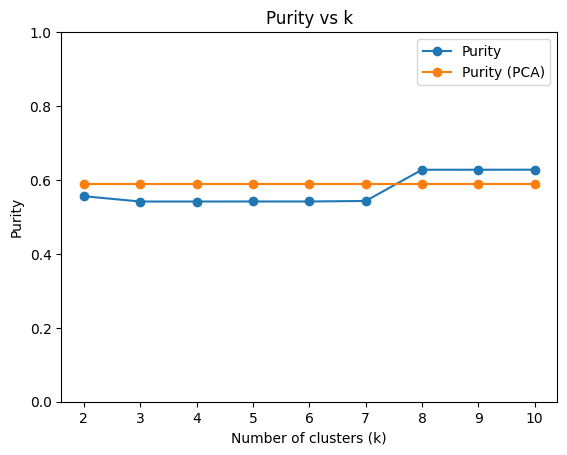

In [18]:
# Znalezienie optymalnego k metodą łokcia
plt.plot(k_values, silhouette_scores, marker='o')
plt.plot(k_values, silhouette_scores_pca, marker='o')
plt.legend(['SS', 'SS (PCA)'])
plt.title('Silhouette Score vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

plt.plot(k_values, wcss, marker='o')
plt.plot(k_values, wcss_pca, marker='o')
plt.legend(['WCSS', 'WCSS (PCA)'])
plt.title('WCSS vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

plt.plot(k_values, purities_original, marker='o')
plt.plot(k_values, purities_pca, marker='o')
plt.ylim(0, 1)
plt.legend(['Purity', 'Purity (PCA)'])
plt.title('Purity vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Purity')
plt.show()


In [19]:
print(silhouette_scores_pca)

[np.float64(0.9605915355142716), np.float64(0.9605915355142716), np.float64(0.9605915355142716), np.float64(0.9605915355142716), np.float64(0.9605915355142716), np.float64(0.9605915355142716), np.float64(0.9605915355142716), np.float64(0.9605915355142716), np.float64(0.9605915355142716)]


#### Dane nieznormalizowane

In [20]:
data_pca_NN = pca.fit_transform(data)

In [21]:
# Testowanie różnych wartości k
silhouette_scores_NN = [] # NN - Not Normalized
silhouette_pca_scores_NN = []
cluster_labels_NN = {}
cluster_labels_pca_NN = {}
purities_NN = []
purities_pca_NN = []


for k in k_values:
    print('k =', k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    clusters = kmeans.fit_predict(data)
    clusters_pca = kmeans.fit_predict(data_pca_NN)
    
    silhouette = silhouette_score(data, clusters)
    silhouette_pca = silhouette_score(data_pca_NN, clusters_pca)
    
    purity_original = purity_score(labels, clusters)
    purity_pca = purity_score(labels, clusters_pca)

    silhouette_scores_NN.append(silhouette)
    silhouette_pca_scores_NN.append(silhouette_pca)
    purities_NN.append(purity_original)
    purities_pca_NN.append(purity_pca)
    cluster_labels_NN[k] = clusters
    cluster_labels_pca_NN[k] = clusters_pca

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10


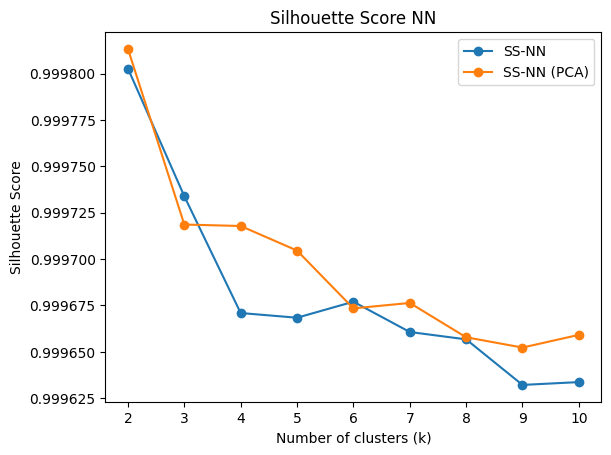

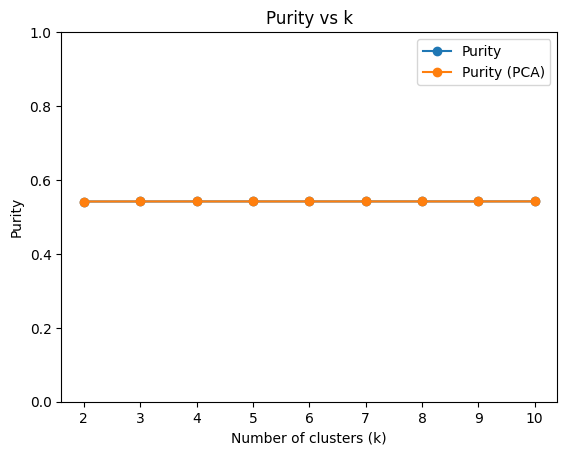

In [22]:
plt.plot(k_values, silhouette_scores_NN, marker='o')
plt.plot(k_values, silhouette_pca_scores_NN, marker='o')
plt.legend(['SS-NN', 'SS-NN (PCA)'])
plt.title('Silhouette Score NN')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

plt.plot(k_values, purities_NN, marker='o')
plt.plot(k_values, purities_pca_NN, marker='o')
plt.ylim(0, 1)
plt.legend(['Purity', 'Purity (PCA)'])
plt.title('Purity vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Purity')
plt.show()

$c)$ Spróbuj ustalić, które cechy są kluczowe przy podziale obserwacji na klastry (np. mapa cieplna z dendrogramem dla niewielkiej reprezentatywnej próbki obserwacji, wykorzystanie *PCA* i obrazowanie danych w przestrzeni 2D z użyciem *biplot*).

In [23]:

def plot_pca_biplot(pca, components, feature_names, title="PCA Biplot"):
    """
    Tworzy biplot PCA pokazujący wpływ cech na główne składowe.

    Parameters:
    - pca: Dopasowany obiekt PCA z sklearn.
    - components: Zredukowane dane w przestrzeni PCA (np. X_pca).
    - feature_names: Lista nazw cech (np. kolumny z oryginalnego zbioru danych).
    - title: Tytuł wykresu.
    """
    plt.figure(figsize=(12, 8))

    # Scatter plot danych w przestrzeni PCA
    plt.scatter(components[:, 0], components[:, 1], alpha=0.5, edgecolor="k")

    # Strzałki dla cech
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    for i, (x, y) in enumerate(loadings[:, :2]):  # Tylko dla dwóch pierwszych składowych
        plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.02, head_length=0.03)
        plt.text(x * 1.15, y * 1.15, feature_names[i], color='red', fontsize=10)

    # Oś OX i OY
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)

    plt.title(title)
    plt.xlabel("Składowa 1 (PC1)")
    plt.ylabel("Składowa 2 (PC2)")
    # plt.xlim((-1.0, 1.0))
    # plt.ylim((-1.0, 1.0))
    plt.grid(alpha=0.3)
    plt.show()

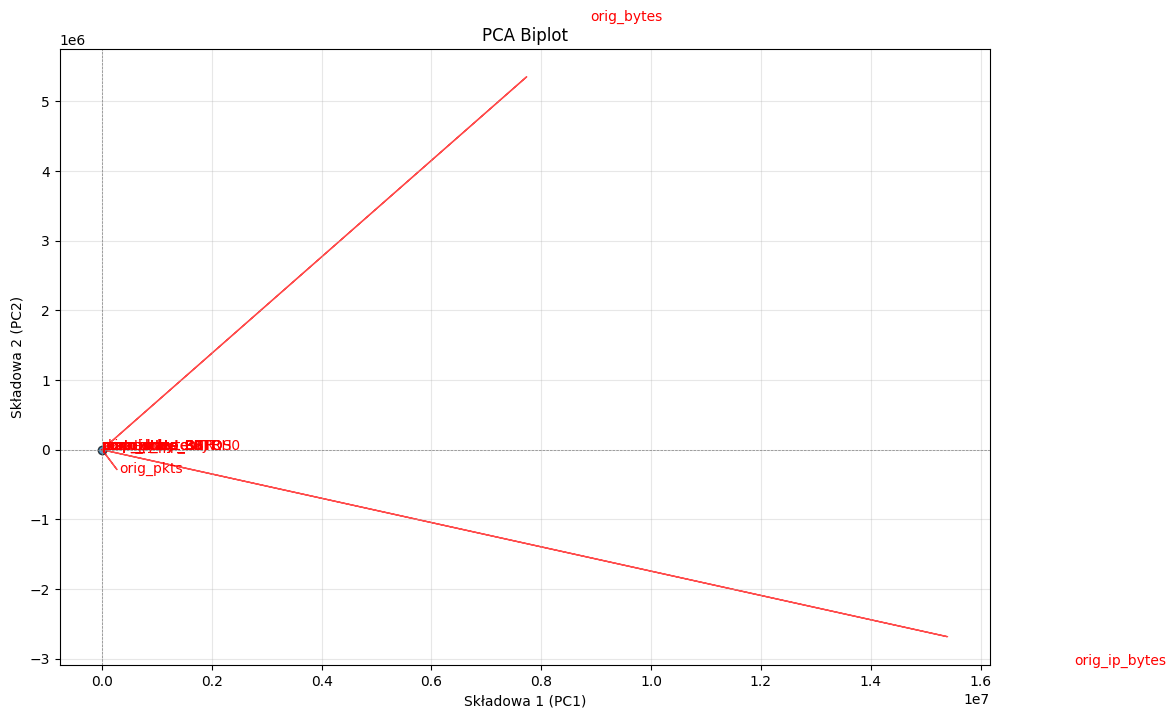

In [24]:
plot_pca_biplot(pca, pca.components_, data.columns, title="PCA Biplot")

In [25]:

print(pca.explained_variance_)
# Interpretacja cech wpływających na PCA
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features = data.columns

pca_info = [{}, {}]

for i, component in enumerate(loadings.T):
    for feature, loading in zip(features, component):
        pca_info[i][feature] = loading

# Sortowanie cech według wpływu na składowe PCA
sorted_pca_info = [{}, {}]

for i in range(2):
    sorted_pca_info[i] = dict(sorted(pca_info[i].items(), key=lambda item: abs(item[1]), reverse=True))

print("\nPosortowane cechy według wpływu na składowe PCA:")
for i in range(2):
    print(f"\nSkładowa {i + 1}:")
    for feature, loading in sorted_pca_info[i].items():
        print(f"{feature}: {loading:.2f}")

[2.97000237e+14 3.59495925e+13]

Posortowane cechy według wpływu na składowe PCA:

Składowa 1:
orig_ip_bytes: 15398015.99
orig_bytes: 7734754.34
orig_pkts: 273687.21
resp_ip_bytes: 2407.61
resp_bytes: 2317.91
duration: 32.75
resp_pkts: 1.64
missed_bytes: -0.08
proto_udp: 0.01
proto_tcp: -0.01
conn_state_S0: 0.00
conn_state_SF: -0.00
conn_state_REJ: -0.00
conn_state_S3: -0.00
conn_state_RSTR: -0.00
conn_state_OTH: -0.00
proto_icmp: -0.00
conn_state_RSTO: -0.00
conn_state_S1: -0.00
conn_state_S2: -0.00
conn_state_SHR: -0.00
conn_state_RSTOS0: -0.00
conn_state_RSTRH: -0.00
conn_state_SH: -0.00

Składowa 2:
orig_bytes: 5353718.98
orig_ip_bytes: -2684184.49
orig_pkts: -287066.73
resp_ip_bytes: -4068.64
resp_bytes: -3917.17
duration: -30.91
resp_pkts: -2.76
missed_bytes: 0.02
proto_udp: -0.00
proto_tcp: 0.00
conn_state_S0: -0.00
conn_state_SF: 0.00
conn_state_REJ: 0.00
conn_state_S3: 0.00
conn_state_RSTR: 0.00
conn_state_OTH: 0.00
proto_icmp: 0.00
conn_state_RSTO: 0.00
conn_state_S1: 0.00
co